In [1]:
#Import the Libraries
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
# Import Attention layer
from attention import AttentionLayer

In [7]:
from scipy import datasets

data = pd.read_csv("Reviews.csv", nrows=100000)  # Adjust rows if needed
# Drop duplicate/empty values
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [8]:
# Drop duplicate and empty values from the correct dataframe
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
# The dictionary that we will use for expanding the contractions:
contrac_words = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [11]:
# Data-preprocessing
import nltk
nltk.download('stopwords')
# Remove stopwords
stop_words = set(stopwords.words('english')) 
def cleaner_txt(txt,num):
    string = txt.lower() # convert into lowercase
    string = BeautifulSoup(string, "html.parser").text # remove HTML tags
    string = re.sub(r'\([^)]*\)', '', string)
    string = re.sub('"','', string)
    string = ' '.join([contrac_words[t] if t in contrac_words else t for t in string.split(" ")]) # contraction mapping   
    string = re.sub(r"'s\b","",string) # remove 's
    string = re.sub("[^a-zA-Z]", " ", string)# Remove any text inside the parenthesis
    string = re.sub('[m]{2,}', 'mm', string)
    if(num==0):
        tokens = [w for w in string.split() if not w in stop_words]
    else:
        tokens=string.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soupt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#call the function
txt_cleaned = []
for t in data['Text']:
    txt_cleaned.append(cleaner_txt(t,0))
summary_cleaned = []
for t in data['Summary']:
    summary_cleaned.append(cleaner_txt(t,1))

In [17]:
data['txt_cleaned'] = txt_cleaned
data['summary_cleaned'] = summary_cleaned
# Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

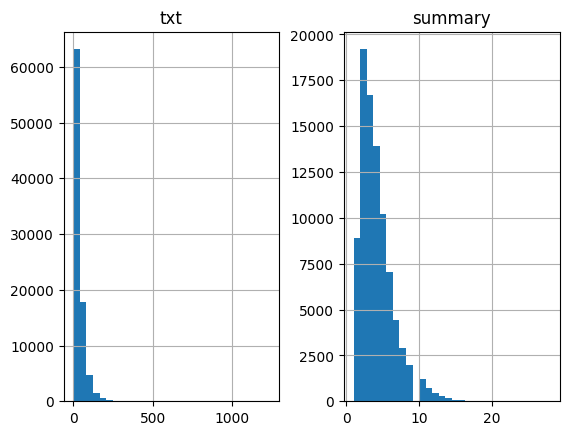

In [20]:
#analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.
import matplotlib.pyplot as plt
word_count_text = []
word_count_summary = []
# populate the lists with sentence lengths
for i in data['txt_cleaned']:
      word_count_text.append(len(i.split()))

for i in data['summary_cleaned']:
      word_count_summary.append(len(i.split()))

len_dataframe = pd.DataFrame({'txt':word_count_text, 'summary':word_count_summary})
len_dataframe.hist(bins = 30)
plt.show()

In [23]:
count = 0
for i in data['summary_cleaned']:
    if len(i.split()) <= 8:
        count += 1
print(count / len(data['summary_cleaned']))

0.9424894452681977


In [26]:
# fix the maximum length of review to 30
max_len_txt = 30
max_len_summary = 8

# select the reviews and summaries whose length falls below or equal to *max_len_txt* and *max_len_summary*
txt_cleaned = np.array(data['txt_cleaned'])
summary_cleaned = np.array(data['summary_cleaned'])

txt_short = []
summary_short = []
for i in range(len(txt_cleaned)):
    if (len(summary_cleaned[i].split()) <= max_len_summary and len(txt_cleaned[i].split()) <= max_len_txt):
        txt_short.append(txt_cleaned[i])
        summary_short.append(summary_cleaned[i])

dataframe = pd.DataFrame({'txt': txt_short, 'summary': summary_short})

# add the *START* and *END* special tokens at the beginning and end of the summary.
dataframe['summary'] = dataframe['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [27]:
# We’ll use 90% of the datasetset as the training dataset and evaluate the performance on the remaining 10% :
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(dataframe['txt']),np.array(dataframe['summary']),test_size=0.1,random_state=0,shuffle=True)

In [28]:
#Text Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# tokenizer for training dataset
tokenizer_x = Tokenizer() 
tokenizer_x.fit_on_texts(list(x_train))

In [29]:
threshold=4
count=0
count_total=0
frequancy=0
frequancy_total=0
for k,v in tokenizer_x.word_counts.items():
    count_total=count_total+1
    frequancy_total=frequancy_total+v
    if(v<threshold):
        count=count+1
        frequancy=frequancy+v
print("% of rare words in vocabulary:",(count/count_total)*100)
print("Total Coverage of rare words:",(frequancy/frequancy_total)*100)

% of rare words in vocabulary: 66.07775273663876
Total Coverage of rare words: 2.94478384433473


In [30]:
#Summary Tokenizer
# tokenizer for training dataset
tokenizer_x = Tokenizer(num_words=count_total-count) 
tokenizer_x.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_tr_seq    =   tokenizer_x.texts_to_sequences(x_train) 
x_val_seq   =   tokenizer_x.texts_to_sequences(x_test)

#padding zero to maximum length
x_train    =   pad_sequences(x_tr_seq,  maxlen=max_len_txt, padding='post')
x_test   =   pad_sequences(x_val_seq, maxlen=max_len_txt, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  tokenizer_x.num_words + 1

In [31]:
#tokenizer for training dataset
tokenizer_y = Tokenizer()   
tokenizer_y.fit_on_texts(list(y_train))

In [32]:
# defining the thresholdold to be 6 which means word whose count is below 6 is considered as a rare word
threshold=6
count=0
count_total=0
frequancy=0
frequancy_total=0
for k,v in tokenizer_y.word_counts.items():
    count_total=count_total+1
    frequancy_total=frequancy_total+v
    if(v<threshold):
        count=count+1
        frequancy=frequancy+v
print("% of rare words in vocabulary:",(count/count_total)*100)
print("Total Coverage of rare words:",(frequancy/frequancy_total)*100)

% of rare words in vocabulary: 78.2646994054173
Total Coverage of rare words: 5.414143049204358


In [33]:
# Define the tokenizer with top most common words for SUMMARY.
#tokenizer for training dataset
tokenizer_y = Tokenizer(num_words=count_total-count) 
tokenizer_y.fit_on_texts(list(y_train))

#convert text to integer
y_train_seq    =   tokenizer_y.texts_to_sequences(y_train) 
y_test_seq   =   tokenizer_y.texts_to_sequences(y_test) 

# padding zero to maximum 
y_train    =   pad_sequences(y_train_seq, maxlen=max_len_summary, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_len_summary, padding='post')

# size of vocabulary
y_vocab  =   tokenizer_y.num_words +1

In [34]:
#check whether word count of start token is equal to length of the training dataset
tokenizer_y.word_counts['sostok'],len(y_train)

(42451, 42451)

In [35]:
# deleting the rows that contain only START and END tokens for training set
index=[]
for i in range(len(y_train)):
    count=0
    for j in y_train[i]:
        if j!=0:
            count=count+1
    if(count==2):
        index.append(i)
y_train=np.delete(y_train,index, axis=0)
x_train=np.delete(x_train,index, axis=0)

In [36]:
# deleting the rows that contain only START and END tokens for testing set
index=[]
for i in range(len(y_test)):
    count=0
    for j in y_test[i]:
        if j!=0:
            count=count+1
    if(count==2):
        index.append(i)
y_test=np.delete(y_test,index, axis=0)
x_test=np.delete(x_test,index, axis=0)

In [37]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [38]:
from tensorflow.keras.layers import Attention

In [39]:
from keras import backend as K 
K.clear_session()
dim_latent = 300
dim_emb=100

# Encoder
en_input = Input(shape=(max_len_txt,))

#embedding layer
en_embedding =  Embedding(x_voc, dim_emb,trainable=True)(en_input)

# lstm 1
en_lstm1 = LSTM(dim_latent,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
en_output1, state_hidden1, state_c1 = en_lstm1(en_embedding)

# lstm 2
en_lstm2 = LSTM(dim_latent,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
en_output2, state_hidden2, state_c2 = en_lstm2(en_output1)

# lstm 3
en_lstm3=LSTM(dim_latent, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
en_outputs, state_hidden, state_c= en_lstm3(en_output2)

# Set up the decoder 
dec_input = Input(shape=(None,))

#embedding layer 
emb_layer_dec = Embedding(y_vocab, dim_emb,trainable=True)
dec_embedding = emb_layer_dec(dec_input)

dec_lstm = LSTM(dim_latent, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
dec_output,dec_fwd_state, dec_back_state = dec_lstm(dec_embedding,initial_state=[state_hidden, state_c])

# # Attention layer

# attention_layer = AttentionLayer(name='attention_layer')
# attention_output, attention_states = attention_layer([en_outputs, dec_output])

# # Concatinate attention input and decoder LSTM output
# dec_concate_input = Concatenate(axis=-1, name='concat_layer')([dec_output, attention_output])

attention_layer = Attention()
attention_output = attention_layer([dec_output, en_outputs])
dec_concate_input = Concatenate(axis=-1)([dec_output, attention_output])

# Dense layer
dec_dense =  TimeDistributed(Dense(y_vocab, activation='softmax'))
dec_output = dec_dense(dec_concate_input)

# Define the model 
model = Model([en_input, dec_input], dec_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │    843,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 30, 300), │    481,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm[0][0]        │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │    197,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    481,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 300) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 600) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  1,186,975 │ concatenate[0][0] │
│ (TimeDistributed)   │ 1975)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,632,275 (17.67 MB)

 Trainable params: 4,632,275 (17.67 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['acc'])

In [41]:
# stop traing once the testing loss increases
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [42]:
# train the model
x=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=10,callbacks=[earlystopping],batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 272s 809ms/step - acc: 0.5659 - loss: 2.9468 - val_acc: 0.5943 - val_loss: 2.7233
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - acc: 0.5915 - loss: 2.6963 - val_acc: 0.5969 - val_loss: 2.6138
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - acc: 0.5955 - loss: 2.5961 - val_acc: 0.6021 - val_loss: 2.5112
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - acc: 0.6002 - loss: 2.5074 - val_acc: 0.6063 - val_loss: 2.4621
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - acc: 0.6040 - loss: 2.4492 - val_acc: 0.6109 - val_loss: 2.4048
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - acc: 0.6083 - loss: 2.3962 - val_acc: 0.6142 - val_loss: 2.3605
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - acc: 0.6118 - loss: 2.3507 - val_acc: 0.6182 - val_loss: 2.3292
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - acc: 0.6153 - loss: 2.3110 - val_acc: 0.6206 - val_loss: 2.3016
Epoch 9/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 357s 

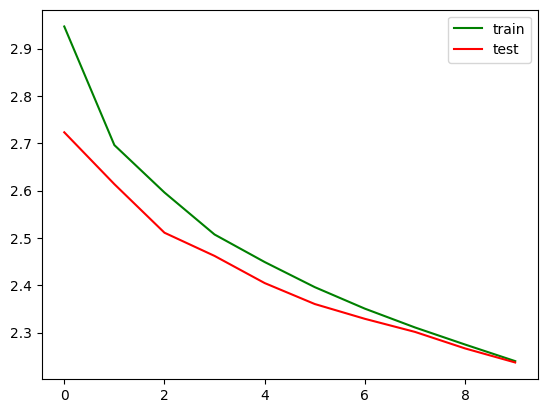

In [43]:
# plot a the behavior of the model over time
from matplotlib import pyplot as plt
plt.plot(x.history['loss'], label='train',color='green')
plt.plot(x.history['val_loss'], label='test',color='red')
plt.legend()
plt.show()

In [44]:
# build the dictionary to convert the index to word for target and source vocabulary
reverce_targat_word_index=tokenizer_y.index_word
reverce_sourse_word_index=tokenizer_x.index_word
targat_word_index=tokenizer_y.word_index

In [45]:
from keras.layers import RepeatVector
from keras.layers import Reshape

In [46]:
# The inference for the encoder and decoder
# Encode the input sequence to get the feature vector
en_model = Model(inputs=en_input,outputs=[en_outputs, state_hidden, state_c])

# Decoder
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(dim_latent,))
decoder_state_input_c= Input(shape=(dim_latent,))
dec_hid_stat_ip = Input(shape=(max_len_txt,dim_latent))

# Get the embeddings of the decoder sequence
dec_embedding2= emb_layer_dec(dec_input) 

dec_output2, state_hidden2, state_c2 = dec_lstm(dec_embedding2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference


#attention inference
attention_output_inf = attention_layer([dec_output2, dec_hid_stat_ip])
dec_inf_con = Concatenate(axis=-1)([dec_output2, attention_output_inf])

#dec_inf_con = Concatenate(axis=-1, name='concat')([dec_output2, attention_output_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
dec_output2 = dec_dense(dec_inf_con) 

# decoder model
dec_model = Model(
    [dec_input] + [dec_hid_stat_ip,decoder_state_input_h, decoder_state_input_c],
    [dec_output2] + [state_hidden2, state_c2])

In [47]:
# Implementation of the inference process
def decode_seq(input_sequence):
    # Encode the input.
    en_out, en_h, en_c = en_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    targat_seq = np.zeros((1,1))
    
    # the first word of target sequence with the start word.
    targat_seq[0, 0] = targat_word_index['sostok']

    stop_cond = False
    dec_sent = ''
    while not stop_cond:
      
        output_tokans, h, c = dec_model.predict([targat_seq] + [en_out, en_h, en_c])

        
        sample_index_tokan = np.argmax(output_tokans[0, -1, :])
        sample_tokan = reverce_targat_word_index[sample_index_tokan]
        
        if(sample_tokan!='eostok'):
            dec_sent += ' '+sample_tokan

        # Exit condition
        if (sample_tokan == 'eostok'  or len(dec_sent.split()) >= (max_len_summary-1)):
            stop_cond = True

        # Update the target sequence.
        targat_seq = np.zeros((1,1))
        targat_seq[0, 0] = sample_index_tokan

        # Update internal states
        en_h, en_c = h, c

    return dec_sent

In [48]:
#convert an integer sequence to a word sequence for summary/reviews
def sequence2summary(input_sequence):
    string=''
    for i in input_sequence:
        if((i!=0 and i!=targat_word_index['sostok']) and i!=targat_word_index['eostok']):
            string=string+reverce_targat_word_index[i]+' '
    return string

def sequence2text(input_sequence):
    string=''
    for i in input_sequence:
        if(i!=0):
            string=string+reverce_sourse_word_index[i]+' '
    return string

In [49]:
# Preticted summary
for i in range(0,100):
    print("Review:",sequence2text(x_train[i]))
    print("Original summary:",sequence2summary(y_train[i]))
    print("Predicted summary:",decode_seq(x_train[i].reshape(1,max_len_txt)))
    print("\n")

Review: daughter used quaker instant oatmeal liked lot long time ago tried version like fact want finish sure maybe lots new ingredients artificial 
Original summary: not very good 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted summary:  great product


Review: liked coffee much subscribing dark rich smooth 
Original summary: makes great cup of java 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted summary:  great coffee


Review: like fool ordered box instead bag try disgusting smell like dead fish rinsed rinsed still smelled right light even look purple crack cannot believe stupid buy 
Original summary: gross 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/s

In [50]:
model.save('model.h5')